I have hourly data for geographical positions, speed over goround, and CO2 emissions from 100 unique container ships for the year 2019. I have also loaded a list of major ports across the world. Assuming the sample is complete and representative, I intened to present a simple analysis of air pollution around ports. 

In [25]:
import pandas as pd
import sqlite3
import folium
import matplotlib.pyplot as plt

Reading the data:

In [27]:
con = sqlite3.connect("dwh/db")

ships = pd.read_sql_query('select * from ships', con)
ports = pd.read_sql_query('select * from ports', con)


I prepared data for visualisation with a SQL query to and load an aggregated table with ports and total emissions to the database.


In [28]:
ports_emissions_query = """
    SELECT s.closest_port, s.continent, SUM(s.E_CO2_kg) AS total_E_CO2_kg, AVG(s.E_CO2_kg) AS avg_CO2_kg, p.LATITUDE, p.LONGITUDE
    FROM ships s
    LEFT JOIN ports p ON s.closest_port = p.PORT_NAME
    WHERE s.closest_port IS NOT NULL
    GROUP BY s.closest_port
"""
ports_emissions = pd.read_sql_query(ports_emissions_query, con)


# Load ports_emissions into the database
ports_emissions.to_sql('ports_emissions', con, if_exists='replace', index=False)

564

In [29]:
ports_emissions = pd.read_sql_query('select * from ports_emissions', con)

I used this data to visualise the geographic distribution of relative CO2 emissions from container shipping from this smaple(assuming the sample is representative). This is done through a simple method via the folium library, which requires a location for the center of the map, the coordinates, the values for emissions, and allows adjustments for visual representation.

In [30]:

m = folium.Map(location=[20, 0], tiles="OpenStreetMap", zoom_start=2)

for index, row in ports_emissions.iterrows():
    folium.CircleMarker(
        location=[row['LATITUDE'], row['LONGITUDE']],
        radius=row['total_E_CO2_kg'] / 1000000, 
        popup=f"{row['closest_port']} - {row['total_E_CO2_kg']:.2f} kg",
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7
    ).add_to(m)

m


Which are the most polluted ports in the world (Assuming a representative sample)?

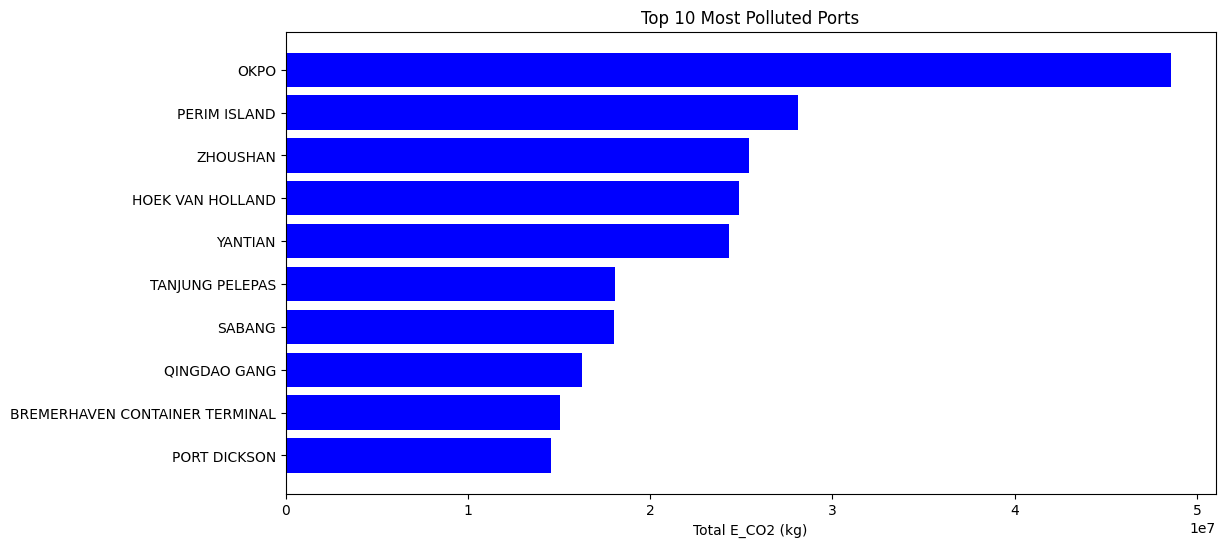

In [31]:
# Sorting the DataFrame by total_E_CO2_kg in descending order
sorted_df = ports_emissions.sort_values(by='total_E_CO2_kg', ascending=False)

# Selecting the top N most polluted ports
top_ports = sorted_df.head(10)  # You can adjust the number as needed

# Plotting the data
plt.figure(figsize=(12, 6))
plt.barh(top_ports['closest_port'], top_ports['total_E_CO2_kg'], color='blue')
plt.xlabel('Total E_CO2 (kg)')
plt.title('Top 10 Most Polluted Ports')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

It can be hypothesized that emissions are more regulated in Europe compared to Africa, and Asia. It would be interesting to see if the data supports this hypothesis. I had a look by comparing average emissions for the four continents present in the dataset.

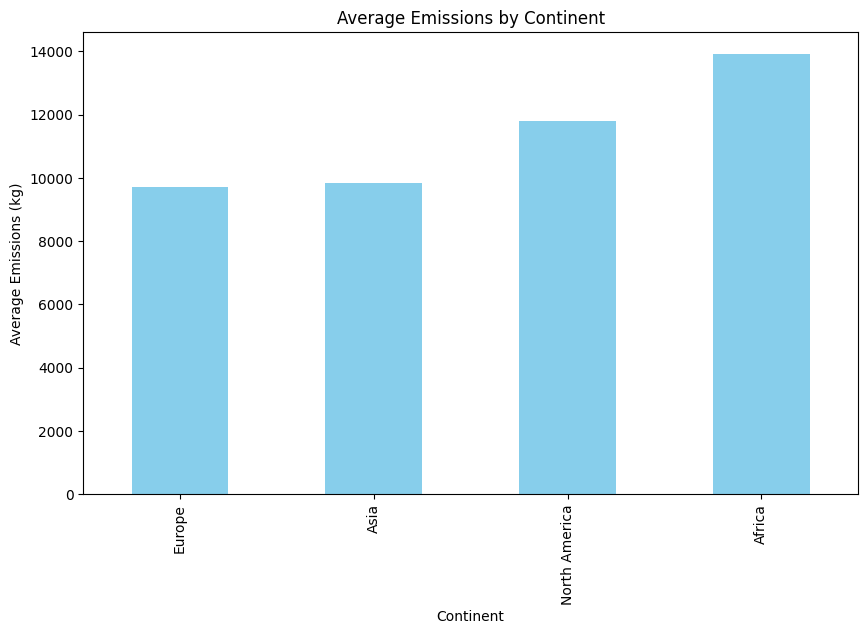

In [32]:
avg_emissions_by_continent = ports_emissions.groupby('continent')['avg_CO2_kg'].mean().sort_values()

# Plotting the data
plt.figure(figsize=(10, 6))
avg_emissions_by_continent.plot(kind='bar', color='skyblue')
plt.xlabel('Continent')
plt.ylabel('Average Emissions (kg)')
plt.title('Average Emissions by Continent')
plt.show()


The results show that average emissions are higher in Africa compared to Europe as expected. There are too few data entries for North America making it difficult to draw any conclusions. The emissions in Asia are comparable to those of Europe in Average.  

What is the share of emissions at port compared to emissons at sea? I can define the emissions at sea for the entries that have null values for the closest_port column in the ships table. emissions at ports are those that have values at that column. I can now visulaise this using a pie chart. 

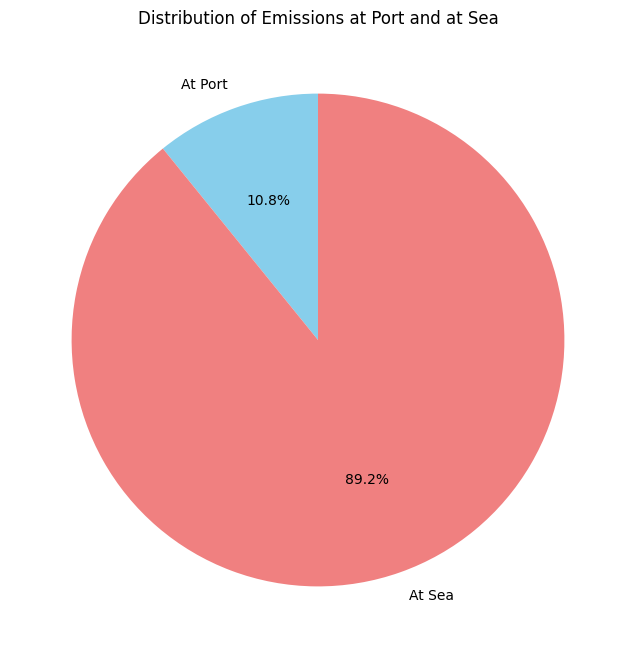

In [33]:

at_port = ships.dropna(subset=['closest_port'])

at_sea = ships[ships['closest_port'].isnull()]

total_emissions_at_port = at_port['E_CO2_kg'].sum()
total_emissions_at_sea = at_sea['E_CO2_kg'].sum()

# Creating a DataFrame for pie chart
data = {'Category': ['At Port', 'At Sea'],
        'Total Emissions': [total_emissions_at_port, total_emissions_at_sea]}

pie_df = pd.DataFrame(data)

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(pie_df['Total Emissions'], labels=pie_df['Category'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Distribution of Emissions at Port and at Sea')
plt.show()


The fact that more than 10 percent of emissions occur at port is alarming. It does however mean that providing shoreside electricity (or cold ironing in maritime terms) have the potential to decrease carbon emissions from global container shipping supply chains by over 10 percent. This can be an important insight for policy makers.